## **Lưu ý: Đây là notebook thứ 3 trong số 4 file notebook**

# **Lần này sử dụng thử kiến trúc Deep Learning với CNN**

### Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Đường dẫn tới file CSV trong Google Drive
file_path = '/content/drive/My Drive/Data/icml_face_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.shape

(35887, 2)

In [ ]:
""" Kiểm tra số lượng row của từng class """

emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


### Đối với model train nhanh như KNN, ta x2 dữ liệu lên

In [ ]:
# import pandas as pd

# df_2 = pd.DataFrame(columns=df.columns)

# for emotion in emotion_counts.index:
#     # Lấy tất cả các row tương ứng với emotion hiện tại
#     emotion_df = df[df['emotion'] == emotion]

#     # Duplicate các row
#     duplicated_emotion_df = pd.concat([emotion_df] * 2, ignore_index=True)

#     # Append vào dataframe mới
#     df_2 = pd.concat([df_2, duplicated_emotion_df], ignore_index=True)

# """ ------------------------------------------------------------------------ """

# # Kiểm tra số lượng row của từng class trong df_2
# emotion_counts_2 = df_2['emotion'].value_counts()
# print(emotion_counts_2)

emotion
3    17978
6    12396
4    12154
2    10242
0     9906
5     8004
1     1094
Name: count, dtype: int64


In [ ]:
# df_2.shape

(71774, 2)

### Shuffle dữ liệu để đảm bảo model không bias một cách bất thường

In [ ]:
# df2_shuffled = df_2.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# df2_shuffled.shape

(71774, 2)

### Trục quan hóa images

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

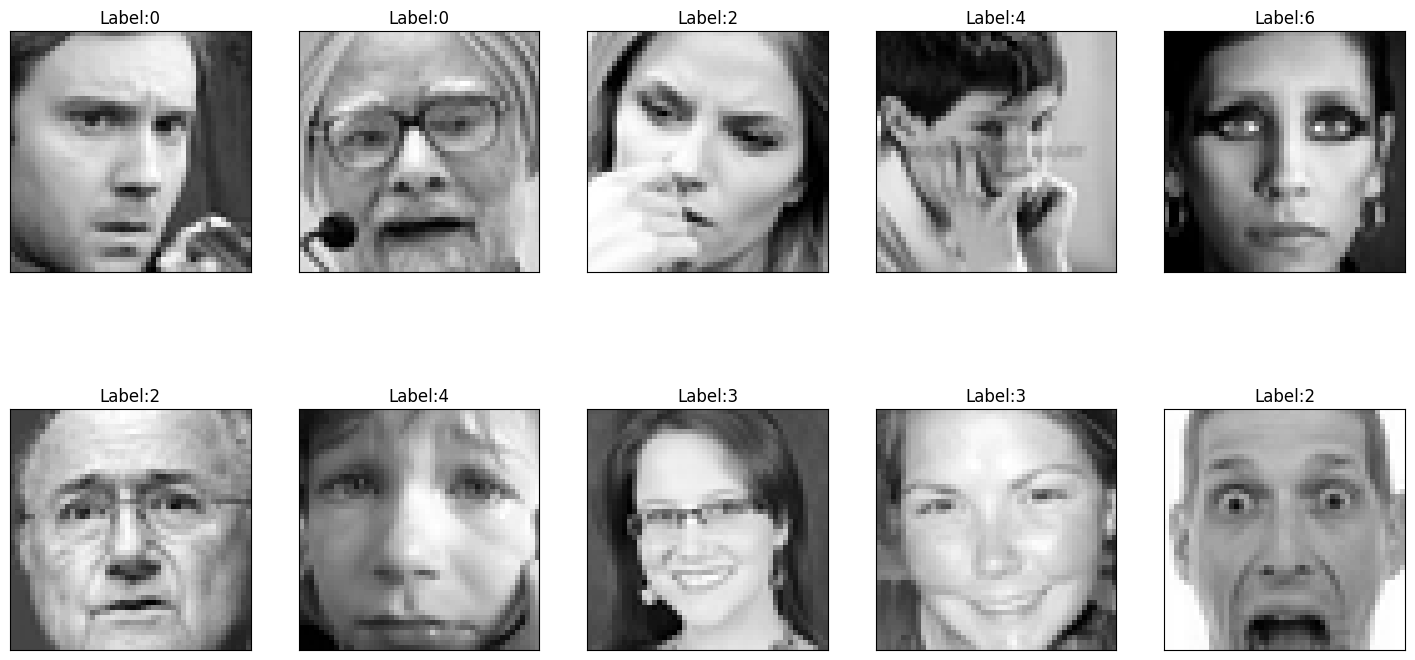

In [ ]:
## showing images here
show_img(images, labels)

In [ ]:
!pip install imgaug

In [ ]:
import numpy as np
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


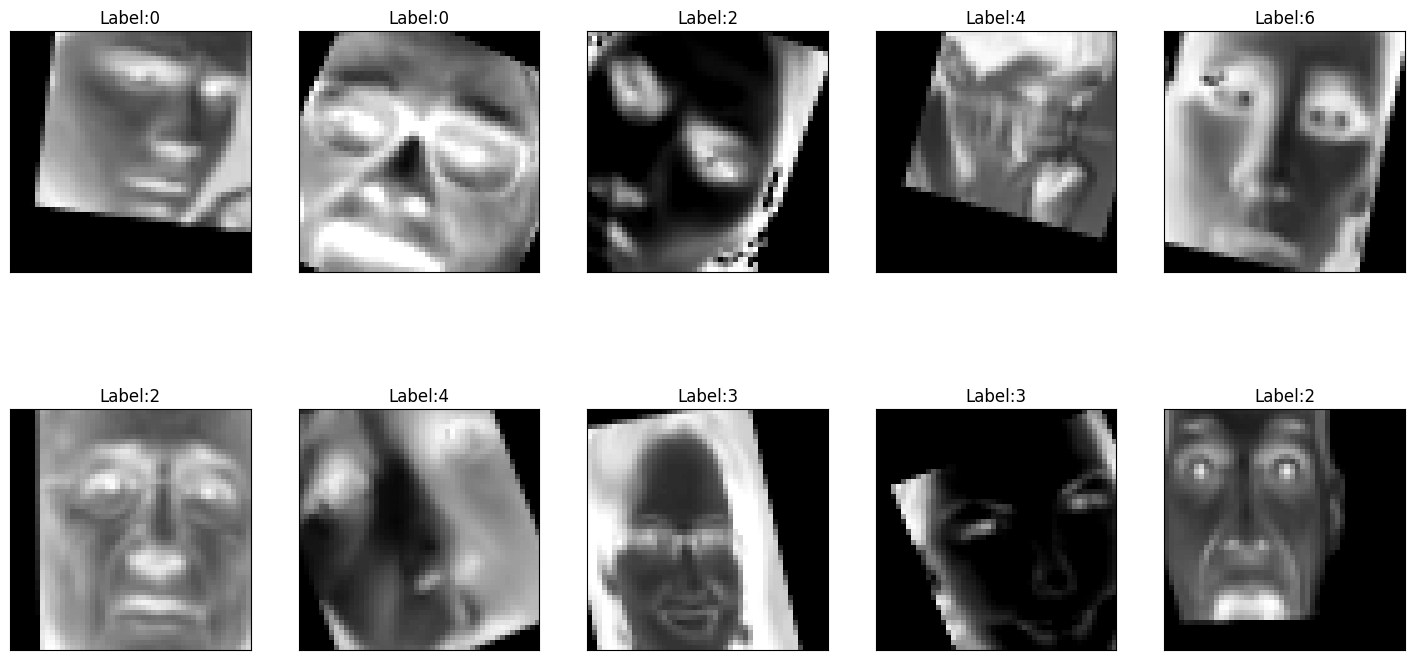

In [ ]:
# Data augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Lật ảnh ngang với xác suất 50%
    iaa.Crop(percent=(0, 0.1)),  # Cắt ngẫu nhiên ảnh với tỉ lệ từ 0 đến 10% mỗi chiều
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Thay đổi tỉ lệ ảnh
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Dịch chuyển ảnh
        rotate=(-25, 25),  # Xoay ảnh
        shear=(-8, 8)  # Biến dạng ảnh
    ),
    iaa.Multiply((0.8, 1.2)),  # Thay đổi độ sáng của ảnh
    iaa.ContrastNormalization((0.75, 1.5))  # Thay đổi độ tương phản của ảnh
])

# Convert images to uint8 before augmentation if they are in float format
if images.dtype == np.float64:
    images = (images * 255).astype(np.uint8)

# Áp dụng augmentation cho một vài hình ảnh để xem kết quả
images_aug = seq(images=images[:10])

# Hiển thị ảnh sau khi augmentation
show_img(images_aug, labels[:10])

In [ ]:
images_aug.shape

(10, 48, 48)

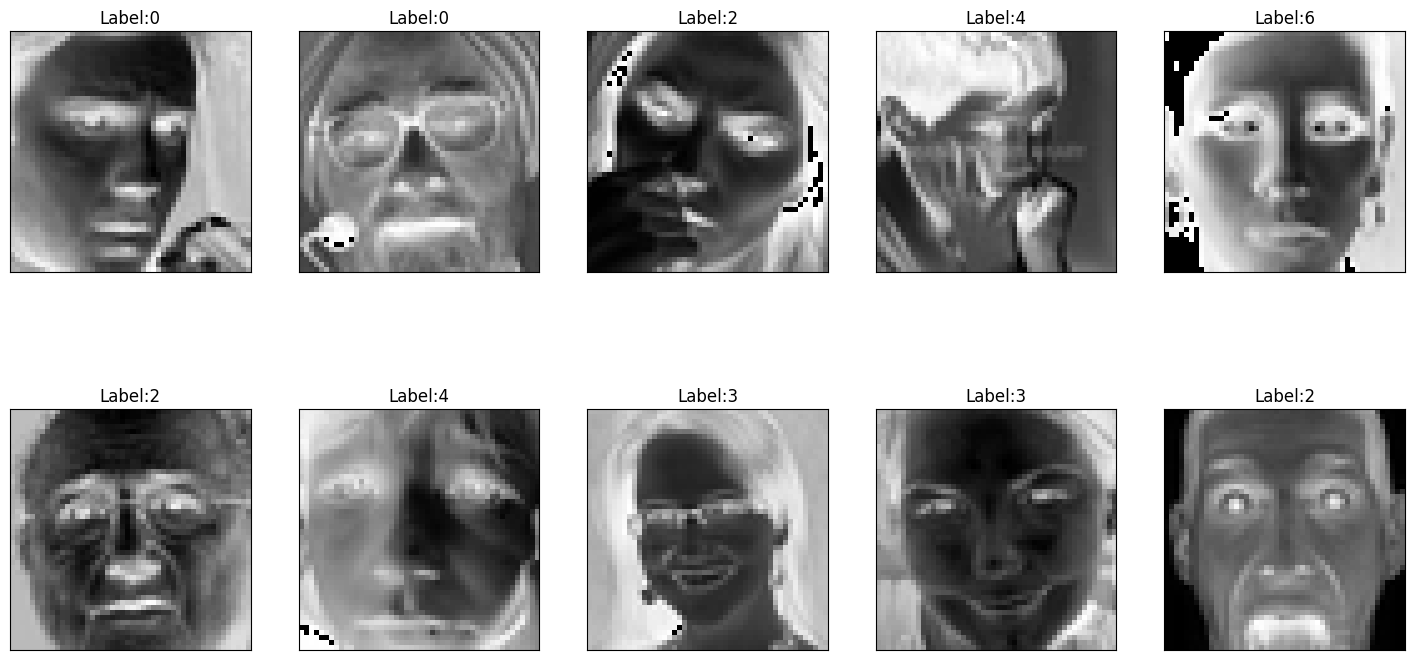

In [ ]:
# Tạo dữ liệu augmented đầy đủ
images_aug_full = seq(images=images)

# Kết hợp dữ liệu gốc và dữ liệu augmented
images_combined = np.concatenate((images, images_aug_full), axis=0)
labels_combined = np.concatenate((labels, labels), axis=0)

# Hiển thị một vài hình ảnh sau khi kết hợp dữ liệu
show_img(images_combined, labels_combined)

In [ ]:
images_combined.shape

(71774, 48, 48)

In [ ]:
labels_AUG = labels

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# 1. Chuẩn hóa dữ liệu
images_combined = images / 255.0
images_combined

array([[[0.2745098 , 0.31372549, 0.32156863, ..., 0.20392157,
         0.16862745, 0.16078431],
        [0.25490196, 0.23921569, 0.22745098, ..., 0.21960784,
         0.20392157, 0.17254902],
        [0.19607843, 0.16862745, 0.21176471, ..., 0.19215686,
         0.21960784, 0.18431373],
        ...,
        [0.35686275, 0.25490196, 0.16470588, ..., 0.28235294,
         0.21960784, 0.16862745],
        [0.30196078, 0.32156863, 0.30980392, ..., 0.41176471,
         0.2745098 , 0.18039216],
        [0.30196078, 0.28235294, 0.32941176, ..., 0.41568627,
         0.42745098, 0.32156863]],

       [[0.59215686, 0.58823529, 0.57647059, ..., 0.50588235,
         0.54901961, 0.47058824],
        [0.59215686, 0.58431373, 0.58431373, ..., 0.47843137,
         0.55294118, 0.5372549 ],
        [0.59215686, 0.59215686, 0.61176471, ..., 0.42745098,
         0.48235294, 0.57254902],
        ...,
        [0.7372549 , 0.7372549 , 0.4745098 , ..., 0.7254902 ,
         0.7254902 , 0.72941176],
        [0.7

In [ ]:
# 2. Chuyển đổi nhãn sang One-Hot Encoding (giả sử biến `labels_AUG` chứa nhãn)
labels_AUG_one_hot = to_categorical(labels_combined, num_classes=7)

In [ ]:
# 3. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(images_normalized,
                                                    labels_AUG_one_hot,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# 4. Reshape hình ảnh (nếu cần)
# Nếu ảnh là grayscale, thêm một kênh vào cuối để có shape (num_samples, 48, 48, 1)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [ ]:
""" 5. Xây dựng mô hình CNN """
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **ACCURACY ĐÃ HỘI TỤ Ở MỨC 52% SAU KHOẢNG 17 EPOCHS `TRÊN TẬP DỮ LIỆU CÓ AUGMENTATION`**

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_test,
                                     y_test))

Epoch 1/25
898/898 [==============================] - 253s 281ms/step - loss: 1.7715 - accuracy: 0.2694 - val_loss: 1.6720 - val_accuracy: 0.3255
Epoch 2/25
898/898 [==============================] - 287s 319ms/step - loss: 1.6339 - accuracy: 0.3469 - val_loss: 1.5216 - val_accuracy: 0.4049
Epoch 3/25
898/898 [==============================] - 253s 282ms/step - loss: 1.5290 - accuracy: 0.3973 - val_loss: 1.4216 - val_accuracy: 0.4504
Epoch 4/25
898/898 [==============================] - 251s 279ms/step - loss: 1.4687 - accuracy: 0.4257 - val_loss: 1.3741 - val_accuracy: 0.4692
Epoch 5/25
898/898 [==============================] - 252s 281ms/step - loss: 1.4273 - accuracy: 0.4487 - val_loss: 1.3611 - val_accuracy: 0.4731
Epoch 6/25
898/898 [==============================] - 243s 271ms/step - loss: 1.3955 - accuracy: 0.4613 - val_loss: 1.3215 - val_accuracy: 0.4967
Epoch 7/25
898/898 [==============================] - 243s 270ms/step - loss: 1.3660 - accuracy: 0.4731 - val_loss: 1.3002 -

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)